# Way Home

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import math

## Set Simulation Params and Create Grid

In [2]:
drunk_velocity = 1 # in m/s 
#car_velocitiy = 10 
car_intensitiy = 0.05 # probability that a car occurs on a lane 

# how many lanes has one direction? one lane is 1m
street_lanes = 2 
street_length = 50


In [3]:
def create_grid(street_lanes=2, street_length=50, car_intensity=0.05, return_empty_grid=False):
    street_width = 3 + 2*street_lanes 
    grid = np.zeros((street_width, street_length))
        
    # compute sideways - start and end row as well as between the directions
    sideways = [0, street_lanes+1, grid.shape[0]-1]
    for i in sideways:
        grid[i,] = 0.25
        
    if return_empty_grid == True:
        return grid, sideways
        
    elif return_empty_grid == False:
        for y in range(grid.shape[0]):
            if y not in sideways:
                for x in range(grid.shape[1]):
                    if (np.random.uniform(0,1,1) < car_intensity).item():
                        grid[y,x] = (0.6)

        # randomly place the person
        grid[0, math.floor(street_length/2)] = 1.0
    
        return grid, sideways

## _A_
- t=1=constant
- change in direction is always $\frac{1}{4}$ probability left, $\frac{1}{4}$ right, $\frac{1}{2}$ forward

### static cars
Cars do appear on a lane or not - velocity is not considered. If the drunk is on a lane where a car appears, he's dead.

In [4]:
def calc_direction_a(last_direction):
    nr_of_steps = 1
    
    # roll persons movement for A
    new_direction = last_direction
    p_dir = np.random.uniform(0,1,1)
    if p_dir < 0.25:
        new_direction -= 90
        #print("left")
    elif 0.25 <= p_dir < 0.5:
        new_direction += 90
        #print("right")
    #else:
        #print("forward")
        
    new_direction = new_direction%360 #modulo 
    dir_coords = (0,0)
    if new_direction == 90:
        dir_coords = (0,1)
    elif new_direction == 180:
        dir_coords = (1,0)
    elif new_direction == 270:
        dir_coords = (0,-1)
    elif new_direction == 0:
        dir_coords = (-1,0)
    
    return dir_coords, new_direction, nr_of_steps

In [11]:
def model_step(grid, sideways=[0,3,6],
               t_constant=True,
               drunk_velocity=1, drunk_direction=180,
               car_intensity=0.05, car_velocity=2,
               plot_progress=False,
               movement_type=calc_direction_a,
               save_plot_progress=False):
    """
        drunk_direction --  0 -> north
                            90 -> east
                            180 -> south
                            270 -> west
    """
    
    # get street length
    street_length = grid.shape[1]
    street_lanes = int((grid.shape[0] - 3)/2)
    
    new_grid = create_grid(street_lanes=street_lanes, street_length=street_length, return_empty_grid=True)[0] # return empty new grid without any placements
    
    """
    # safe grid layout for quick resets
    grid_layout = []
    for i in range(grid.shape[0]):
        if i in sideways:
            grid_layout.append(0.25)
        else:
            grid_layout.append(0)
    """
    
    # get persons coordinates
    y,x = np.unravel_index(grid.argmax(), grid.shape)
    
    hit = False
    finished = False
    
    #############
    ### CARS ####
    #############
    # check where cars are
    car_coords_arr = np.where(grid == 0.6,)
    car_coords = list(zip(car_coords_arr[0], car_coords_arr[1]))
    
    # move cars with velocity
    for car_y, car_x in car_coords:
        # if upper part of street, drive to the left
        if car_y < math.floor(grid.shape[0]/2):
            car_new_x = car_x - car_velocity
            # if the old position of the person, x, is between the new car posi and the old car pos, he got hit
            if (car_new_x <= x < car_x) and car_y == y:
                hit = True
            if car_new_x >= 0:
                new_grid[car_y, car_new_x] = 0.6 # set new if still on the grid, if not on the grid, do nothing
        elif car_y > math.floor(grid.shape[0]/2):
            car_new_x = car_x + car_velocity
            # if the old position of the person, x, is between the new car posi and the old car pos, he got hit
            if (car_new_x >= x > car_x) and car_y == y:
                hit = True
            if car_new_x < grid.shape[1]:
                new_grid[car_y, car_new_x] = 0.6 # set new if still on the grid, if not on the grid, do nothing
    
    # make cars appear with probability car_intensity
    for lane in range(0, grid.shape[0]): 
        if lane not in sideways: 
            car_on_lane = (np.random.uniform(0,1,1) < car_intensity).item()
            if car_on_lane:
                if lane < math.floor(grid.shape[0]/2): # if upper streets
                    new_grid[lane, grid.shape[1]-1] = 0.6
                elif lane > math.floor(grid.shape[0]/2): # if lower streets
                    new_grid[lane, 0] = 0.6
    
    ##############
    ### PERSON ###
    ##############
    direction_coords, new_direction, nr_of_steps = movement_type(drunk_direction) 
    #print(max(y+direction_coords[0],0), (x+direction_coords[1])%street_length )

    if not hit:
        ## if we are on the start row and we would go deeper into negative space, we do not move at all
        ## if we are too far right/left we end up on the other side -> modulo
        new_person_coords = max(y+direction_coords[0],0), (x+direction_coords[1])%street_length 
        # check if new person coordinate would be a car
        if new_grid[new_person_coords] == 0.6:
            hit = True
        else:
            new_grid[new_person_coords] = 1.0 
    
    # if the last row is reached, the drunk survived
    if y+direction_coords[0] == grid.shape[0]-1:
        finished = True
    
    if plot_progress:
        """ 
        plt.figure(figsize=(12,4))
        sns.heatmap(grid, cmap="viridis_r", linewidths=.05, vmin=0, vmax=1)
        plt.title("Old")
        """
        plt.figure(figsize=(12,4))
        heatmap = sns.heatmap(new_grid, cmap="viridis_r", linewidths=.05, vmin=0, vmax=1)
        plt.title("Grid Steps - Car Velocity = {} - Steps = {} - Movement = {}".format(car_velocity, nr_of_steps, direction_coords))
        #heatmap.show()
        
        if save_plot_progress:
            fig = heatmap.get_figure()
            fig.savefig('step_{}.png'.format(nr_of_steps))
        
    
    return new_grid, new_direction, hit, finished

In [35]:
def plot(grid, time, title=None, save=False, save_path='../saved/',show_cbar=True):
    if not title:
        title = 't={}'.format(time)
    if not time:
        time = 'None'
    if save:
        show_cbar = False
        
    plt.figure(figsize=(12,4))
    heatmap = sns.heatmap(grid, cmap="viridis_r", linewidths=.05, vmin=0, vmax=1, cbar=show_cbar)
    plt.title(title)

    if save:
        fig = heatmap.get_figure()
        fig.savefig('{}{}.png'.format(save_path,title))

<ipython-input-35-667af3170a85>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,4))


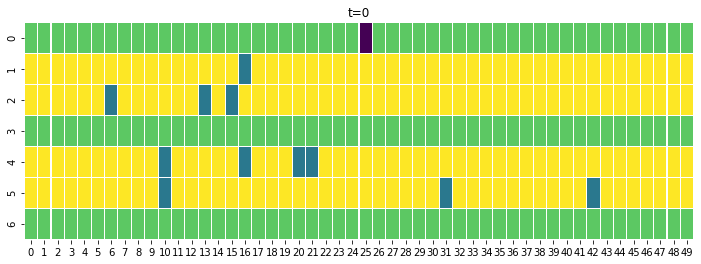

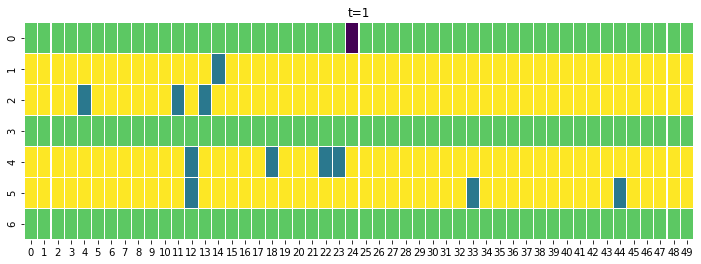

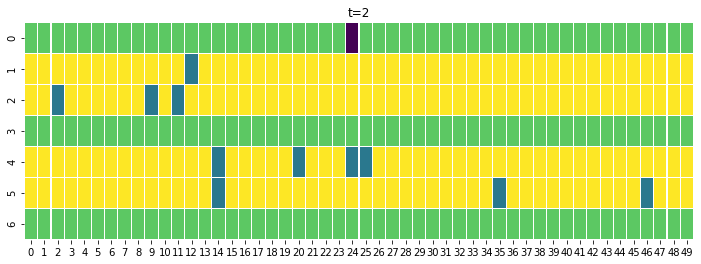

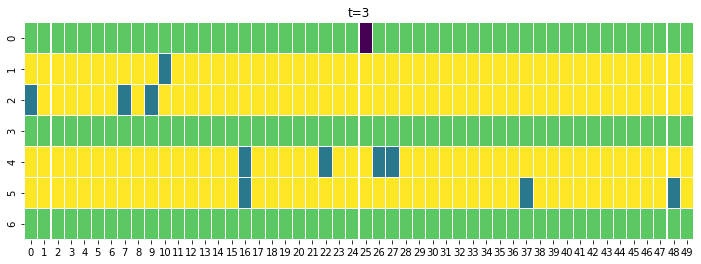

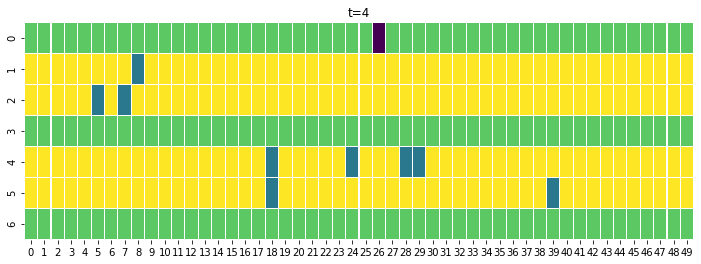

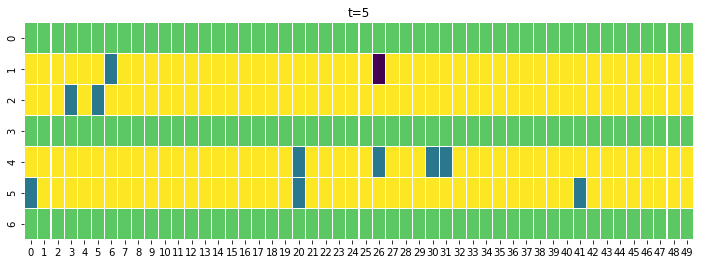

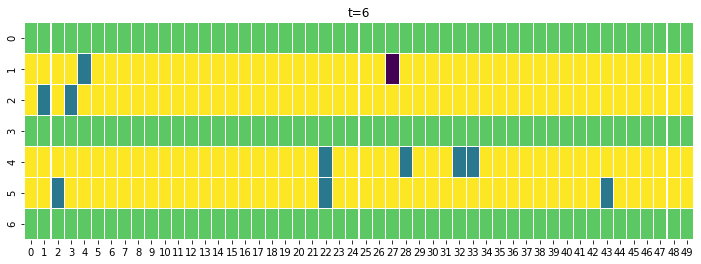

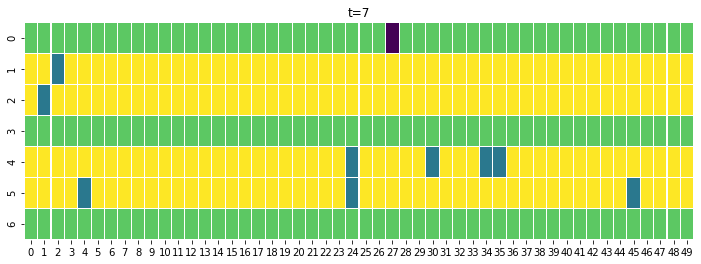

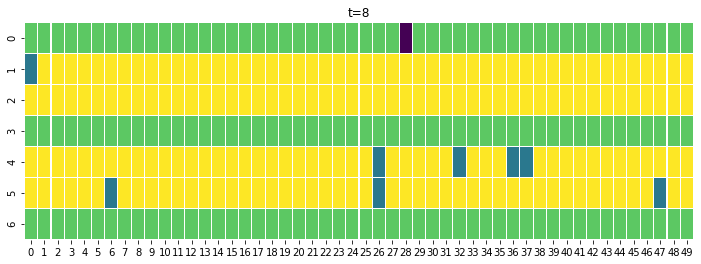

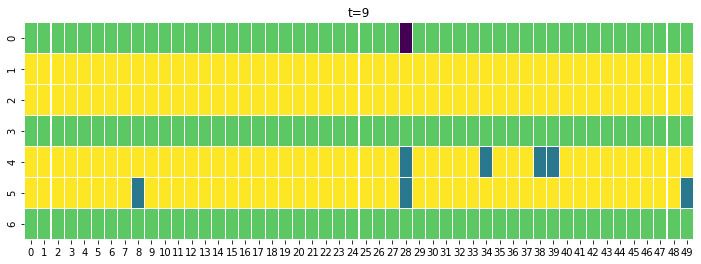

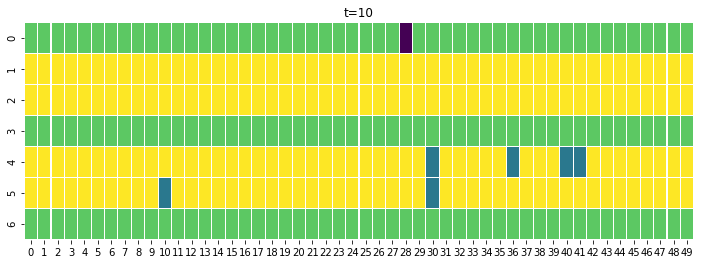

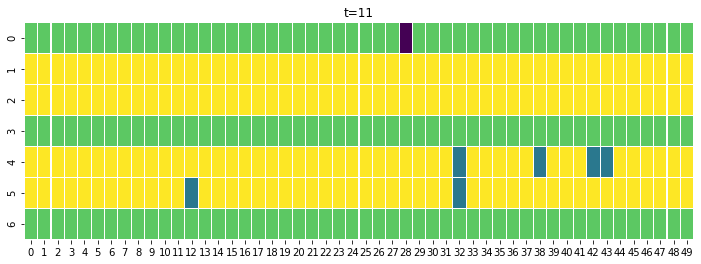

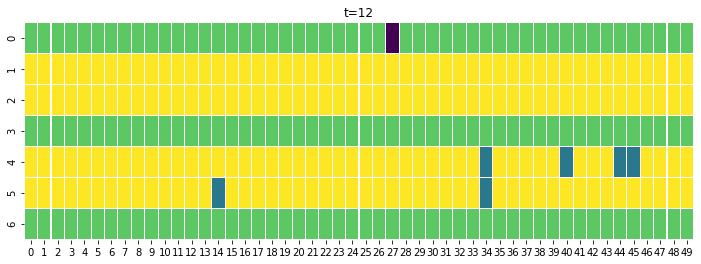

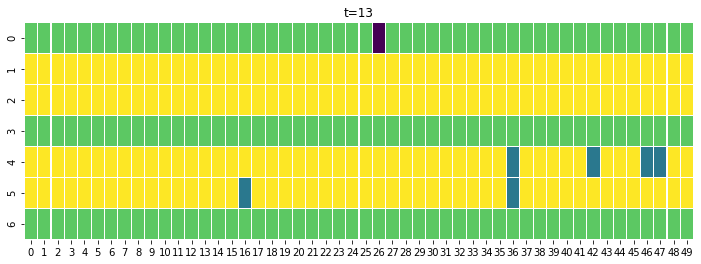

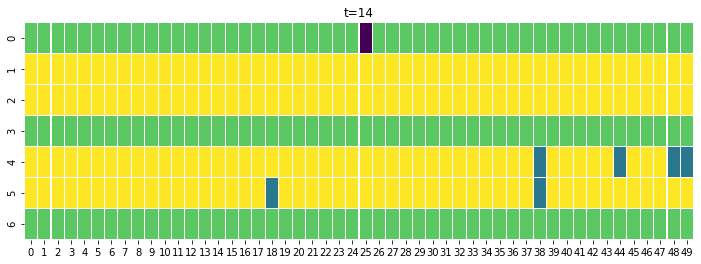

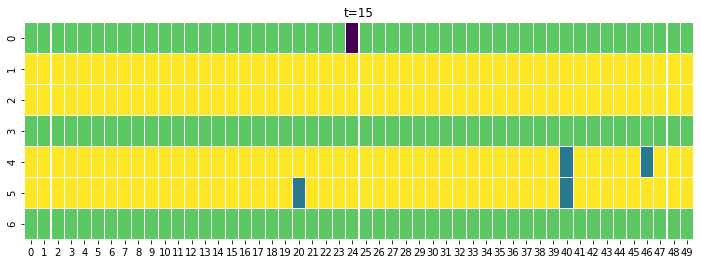

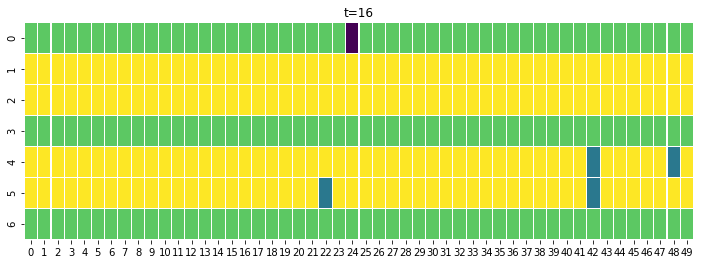

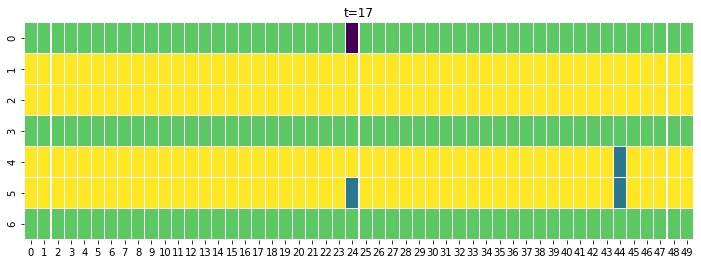

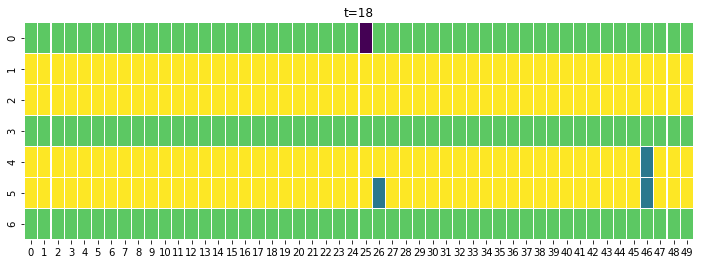

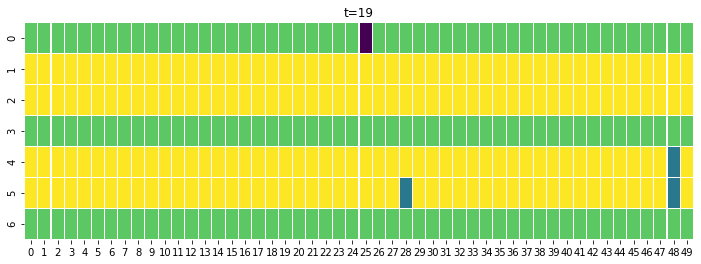

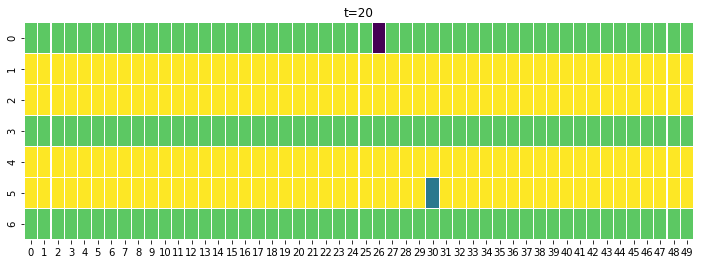

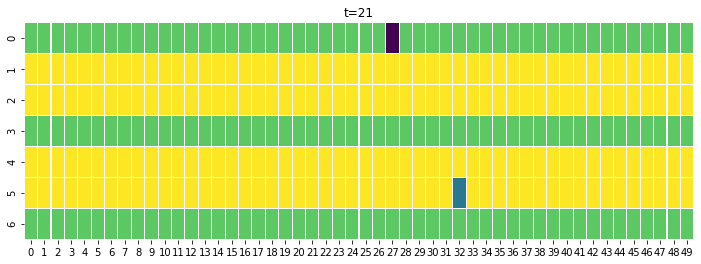

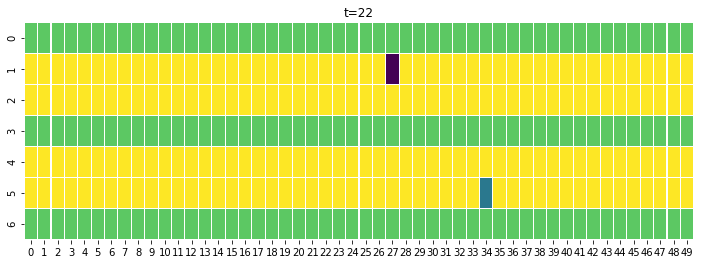

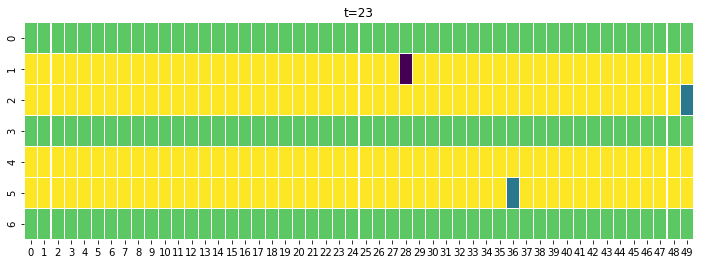

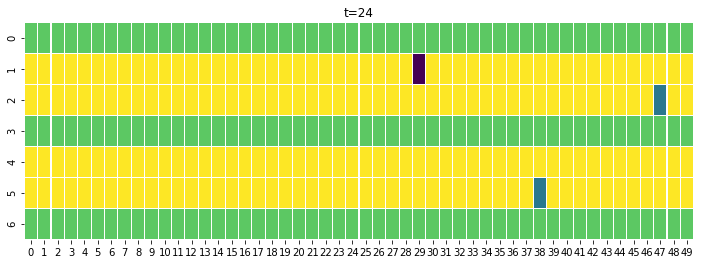

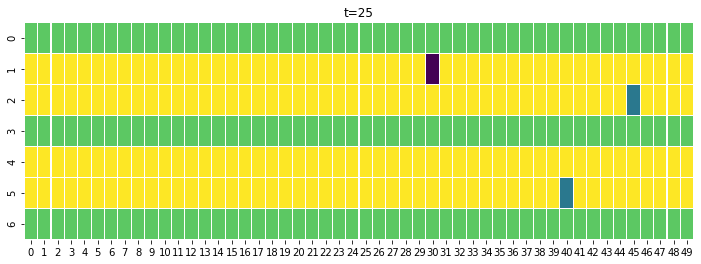

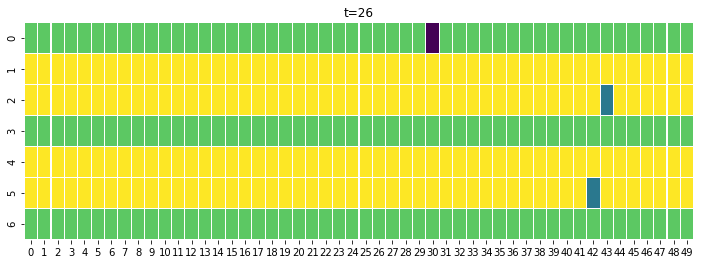

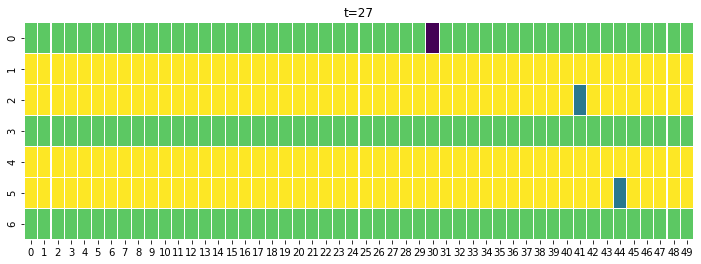

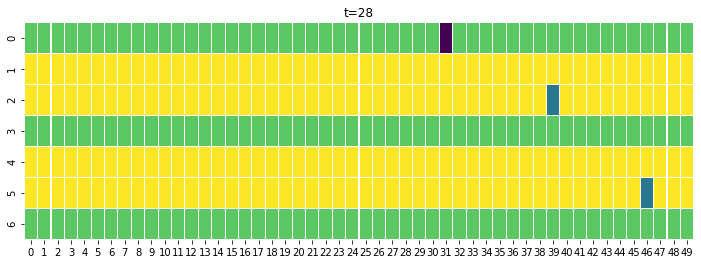

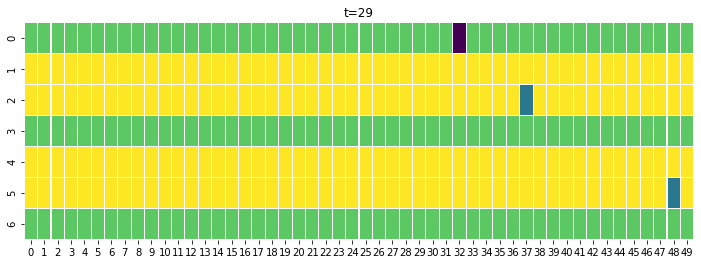

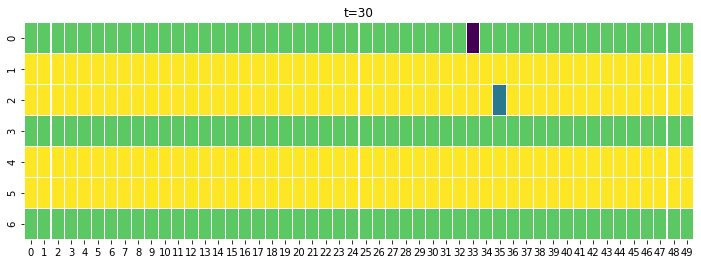

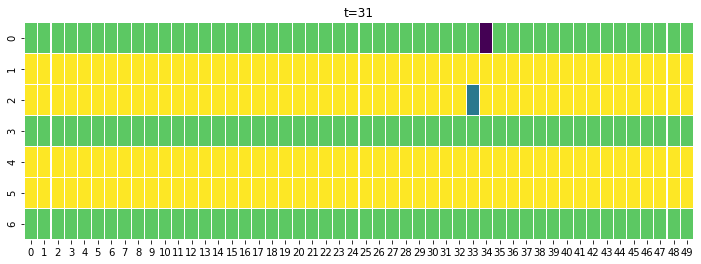

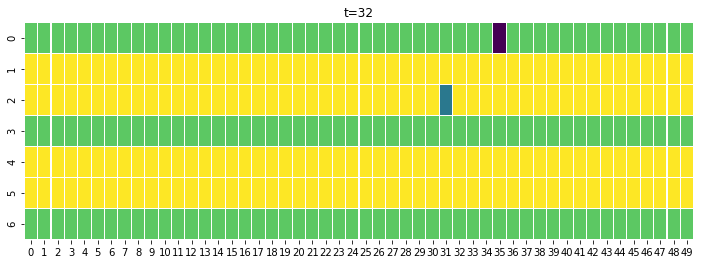

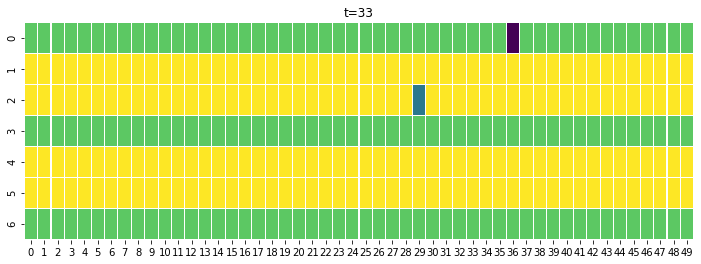

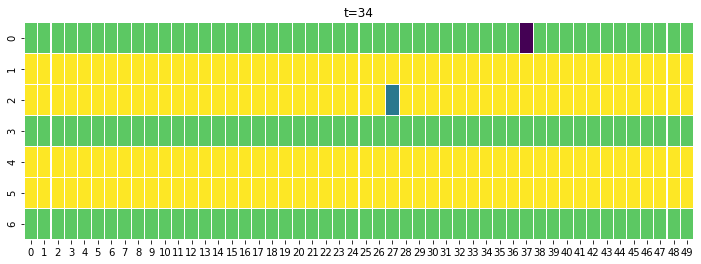

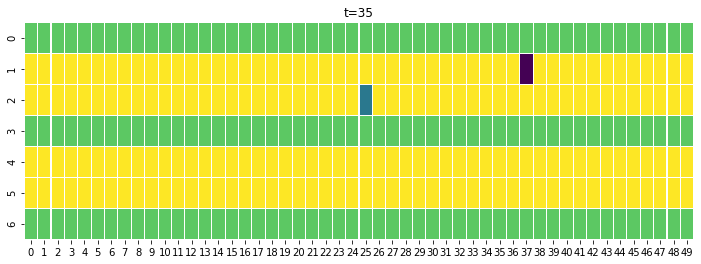

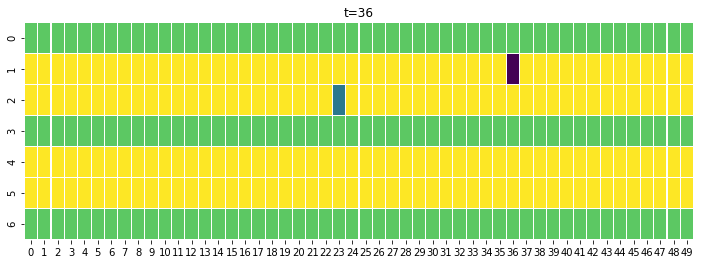

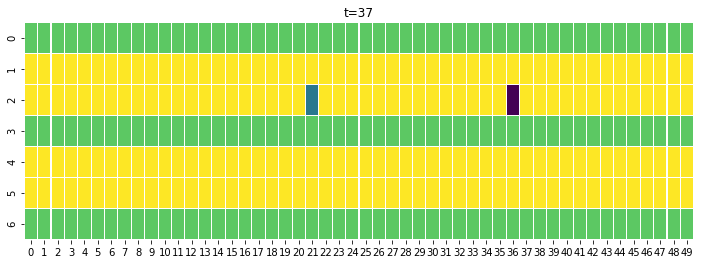

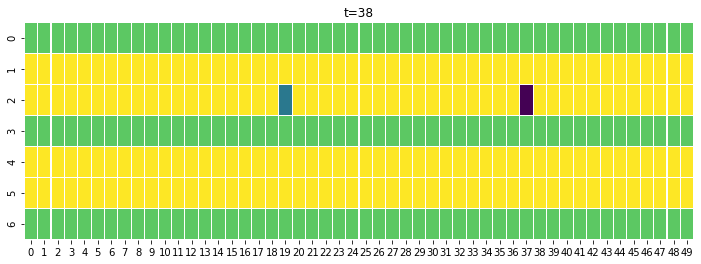

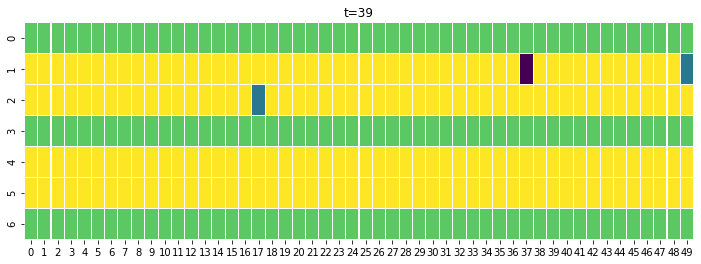

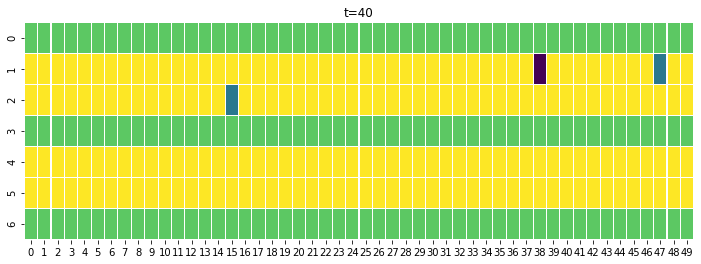

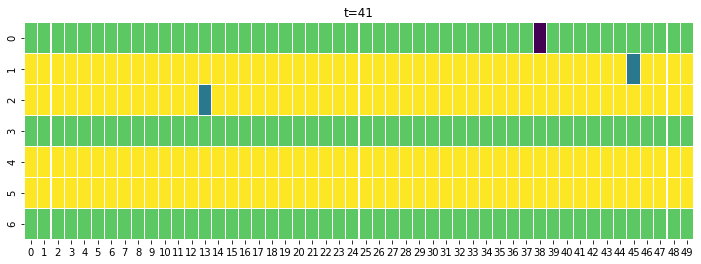

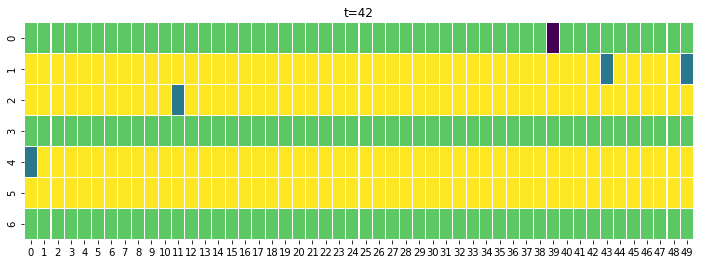

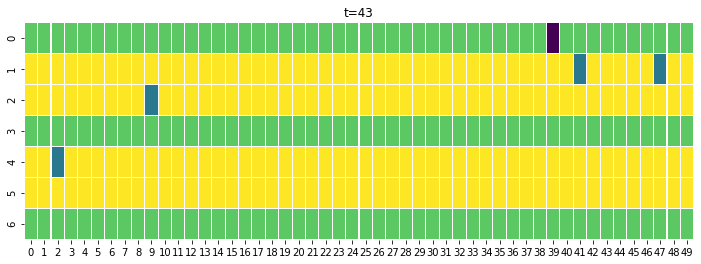

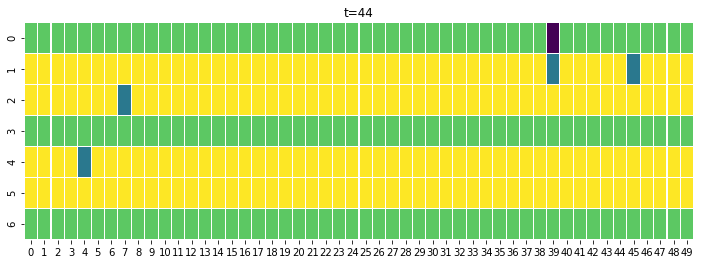

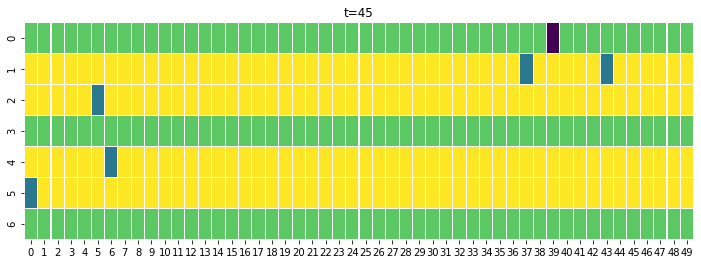

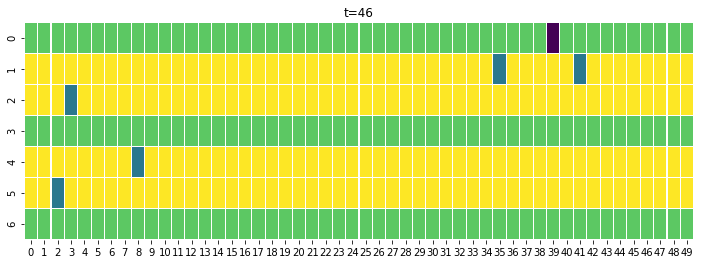

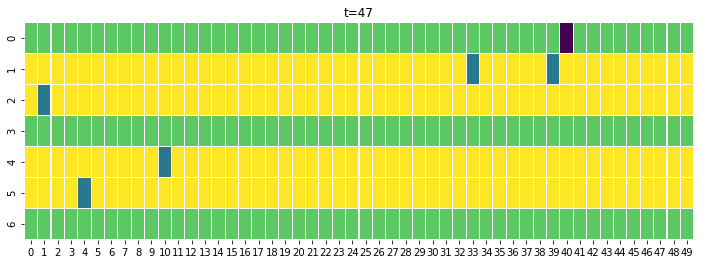

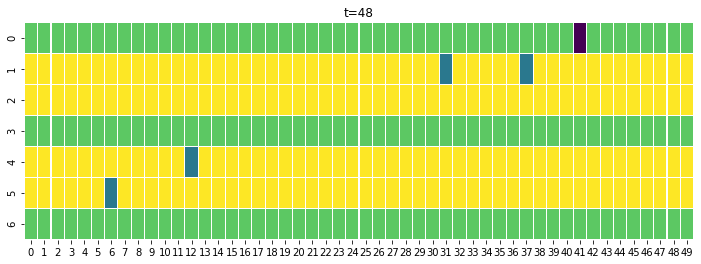

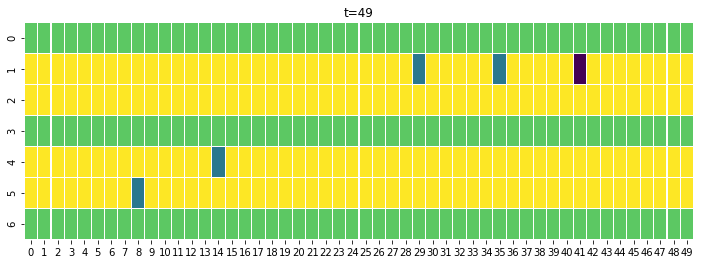

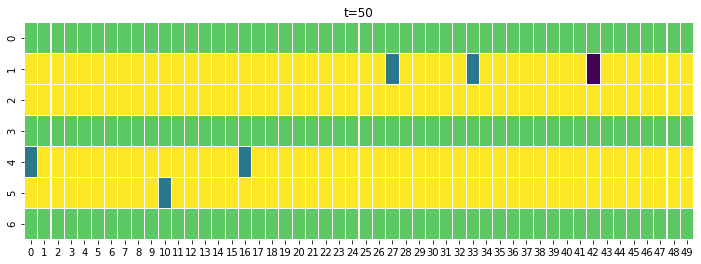

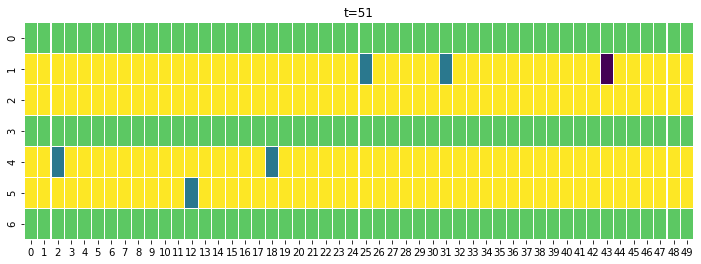

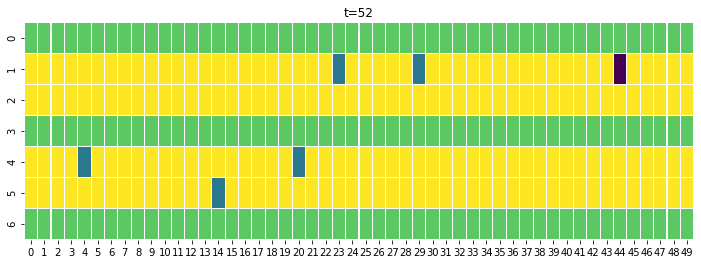

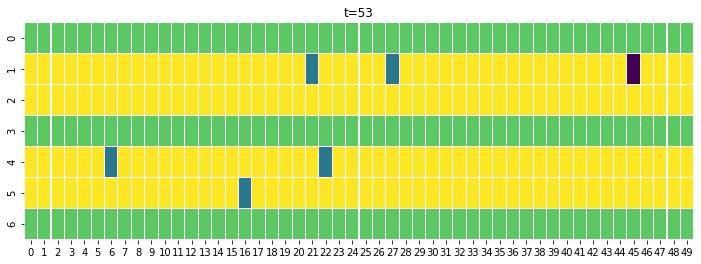

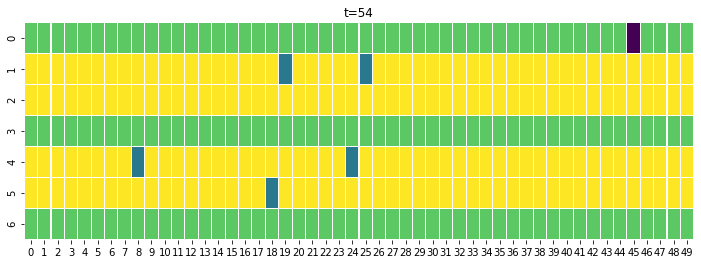

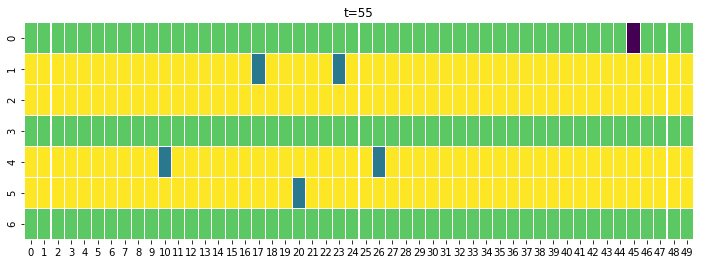

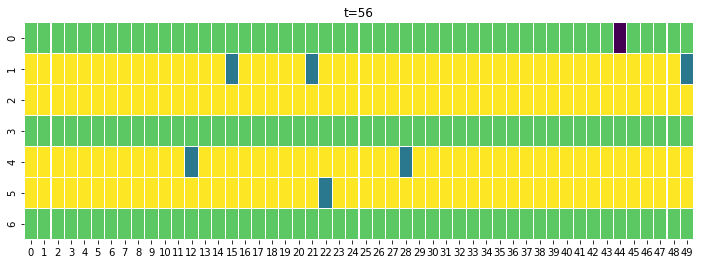

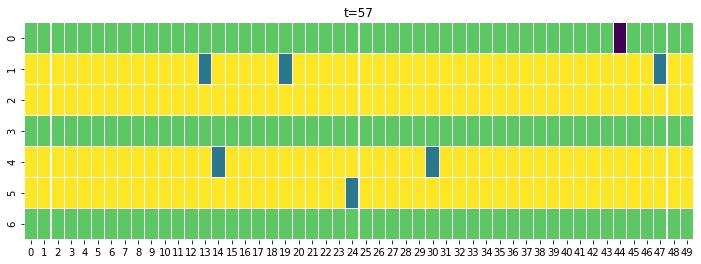

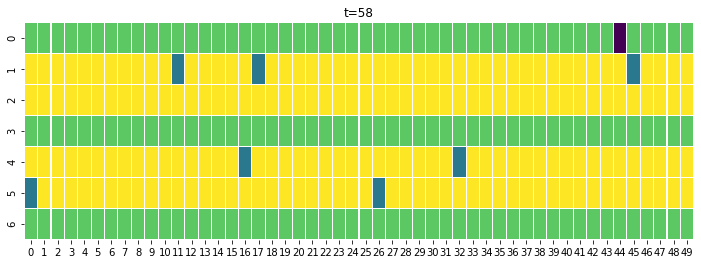

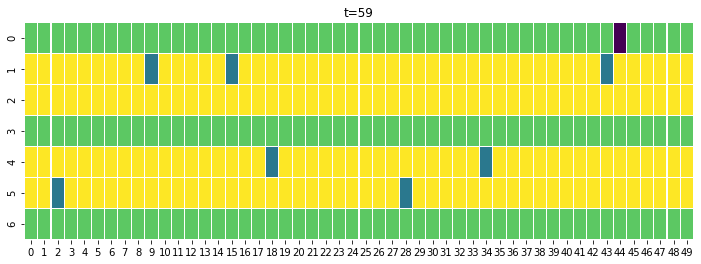

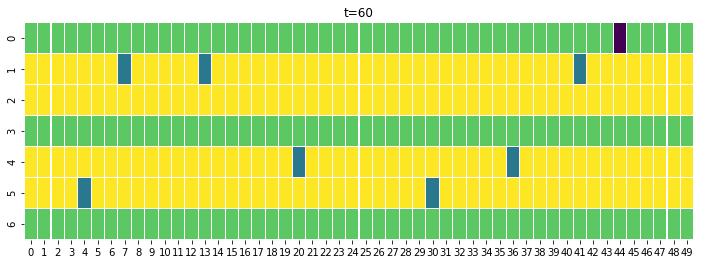

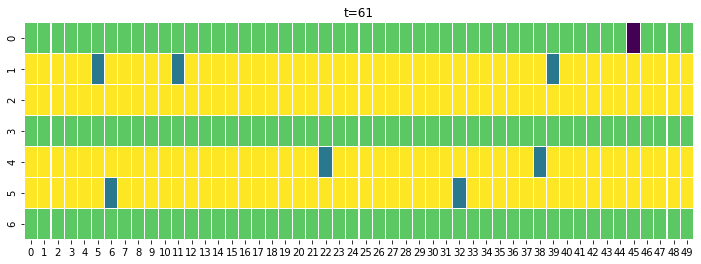

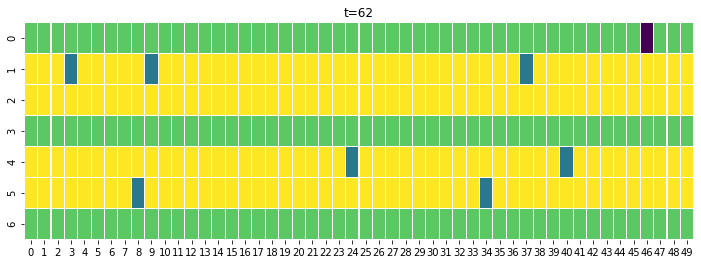

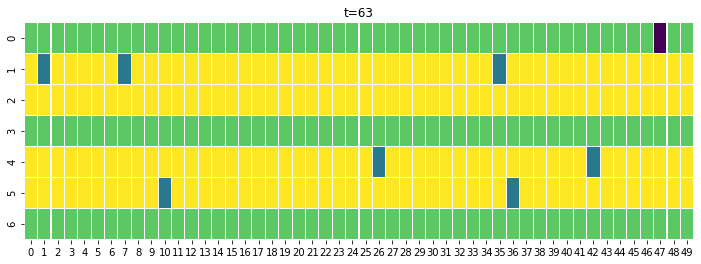

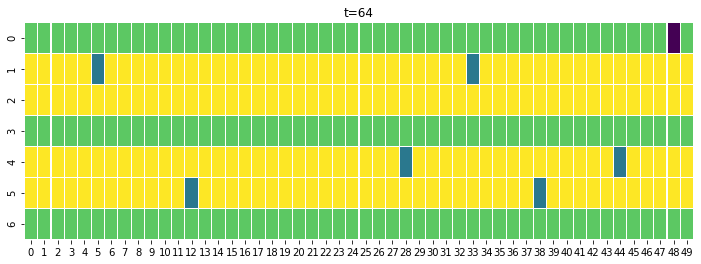

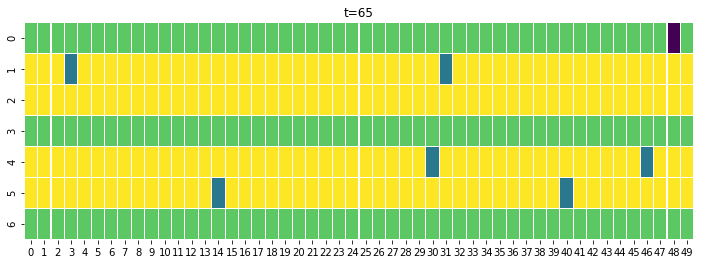

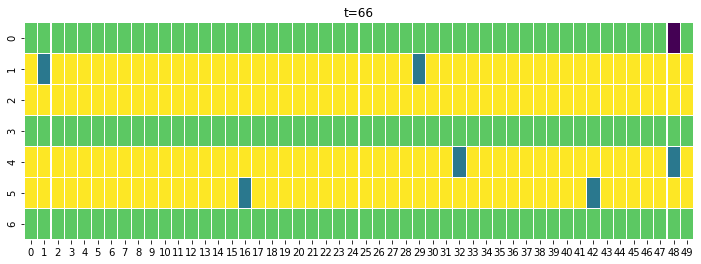

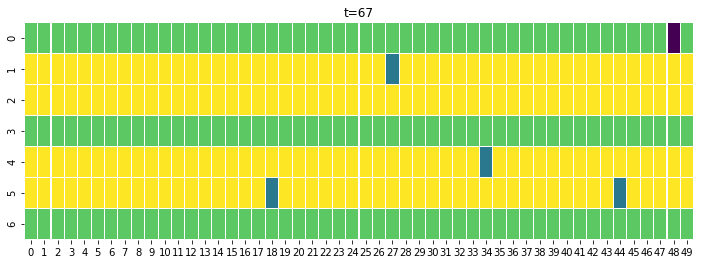

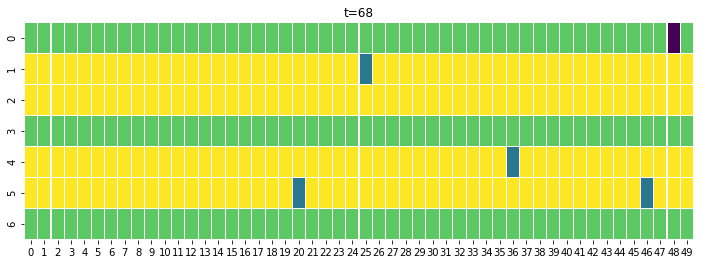

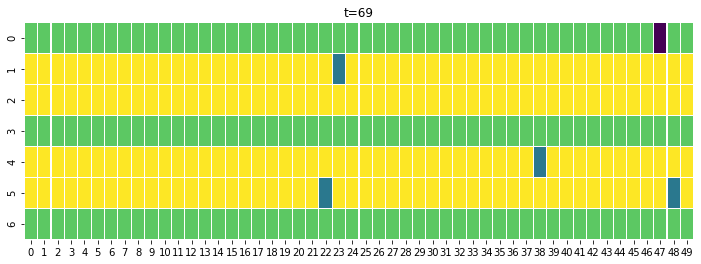

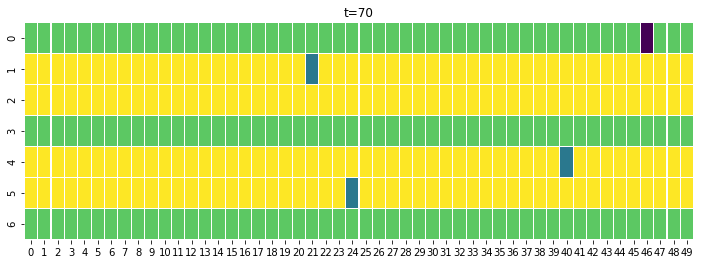

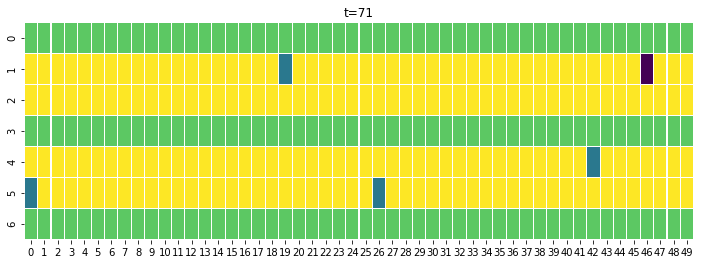

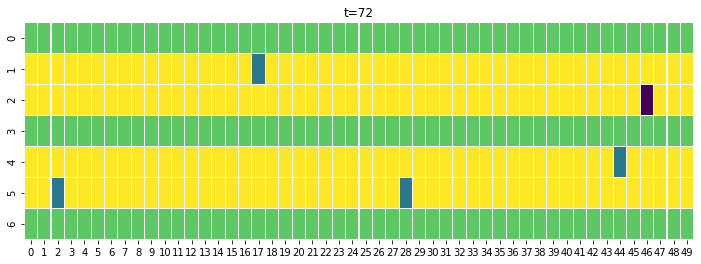

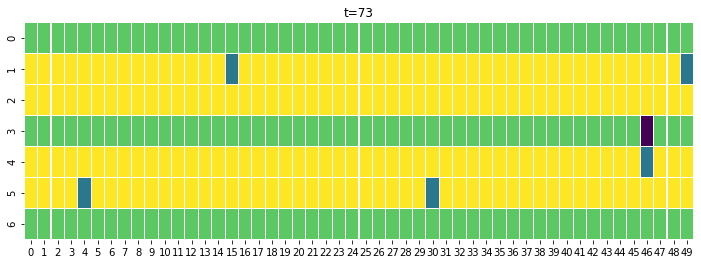

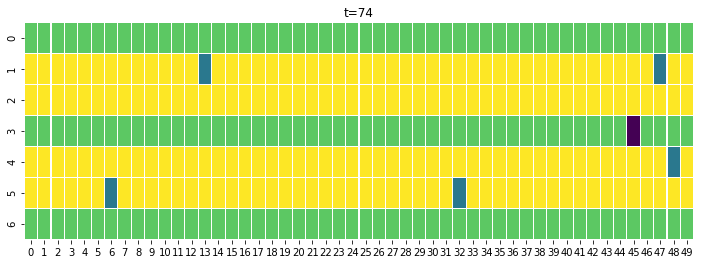

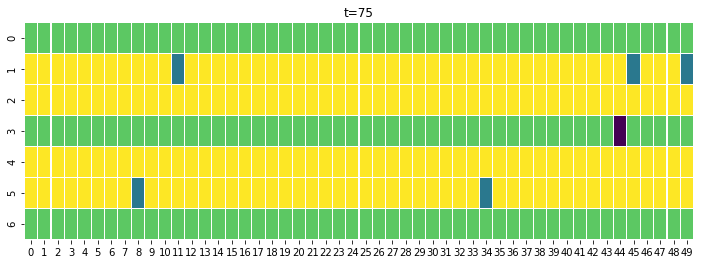

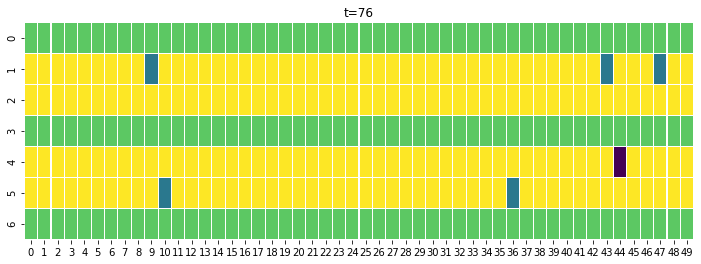

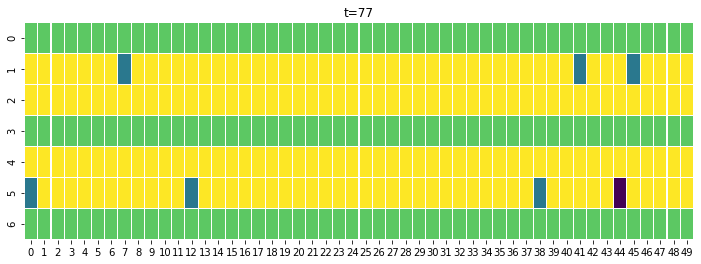

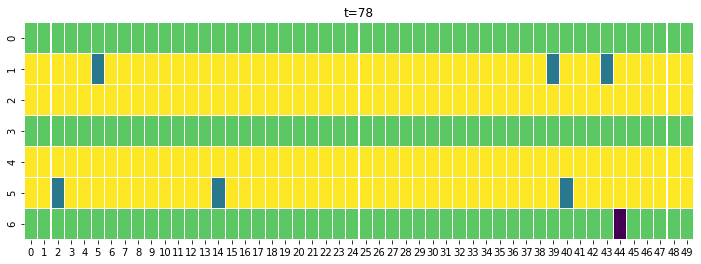

In [36]:
car_int = 0.05
hit = False
fin = False
new_dir = 180
time = 0
grid, sideways = create_grid(street_lanes, street_length, car_int)
plot(grid, time, save=True)

while hit != True and fin != True:
    time += 1
    grid, new_dir, hit, fin = model_step(grid, sideways, drunk_direction=new_dir, car_intensity=car_int)
    plot(grid, time, save=True)

## _B_
- t=1=constant
- new direction = old direction +$\alpha$ with $\alpha$ is uniformly distributed in $[-2/3\pi; +2/3\pi]$

In [37]:
def calc_direction_b(last_direction):
    nr_of_steps = 1
    # roll persons movement for B
    
    # -(2/3)*math.pi, +(2/3)*math.pi --> -120°,120°
    new_direction = last_direction + np.random.uniform(-120, 120, 1)
        
    new_direction = new_direction%360 #modulo 
    dir_coords = (0,0)
    
    if 337.5 <= new_direction < 22.5:
        dir_coords = (-1,0)
    elif 22.5 <= new_direction < 67.5:
        dir_coords = (-1,1)
    elif 67.5 <= new_direction < 112.5:
        dir_coords = (0,1)
    elif 112.5 <= new_direction < 157.5:
        dir_coords = (1,1)
    elif 157.5 <= new_direction < 202.5:
        dir_coords = (1,0)
    elif 202.5 <= new_direction < 247.5:
        dir_coords = (1,-1)
    elif 247.5 <= new_direction < 292.5:
        dir_coords = (0,-1) 
    elif 292.5 <= new_direction < 337.5:
        dir_coords = (-1,-1)
    
    return dir_coords, new_direction, nr_of_steps

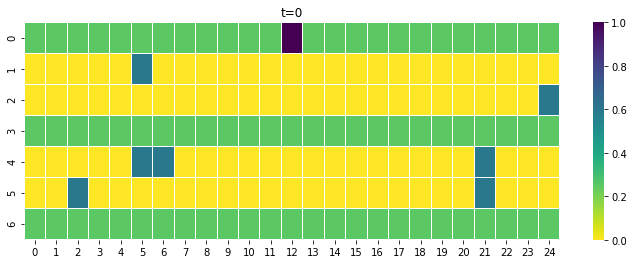

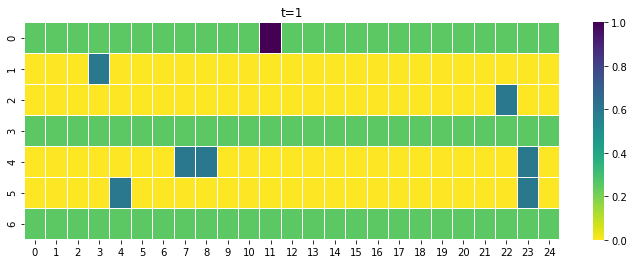

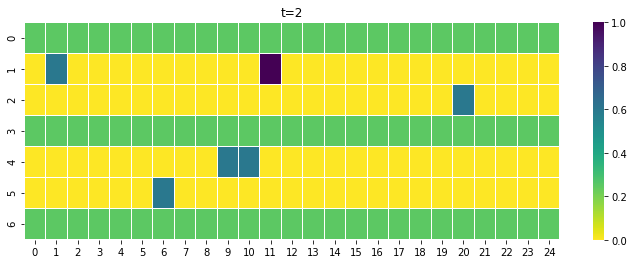

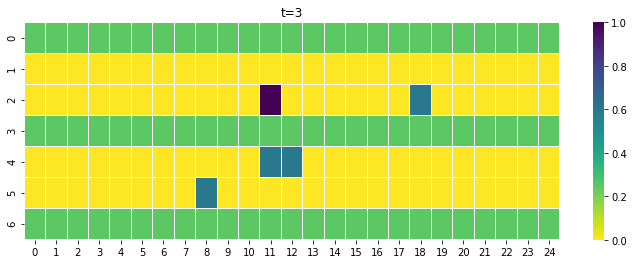

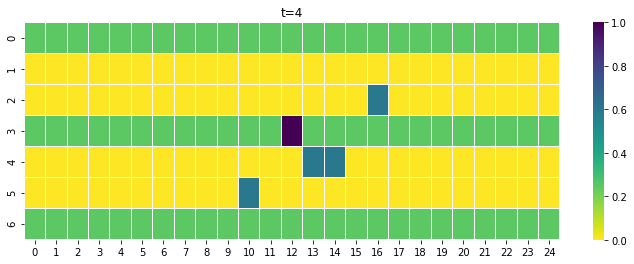

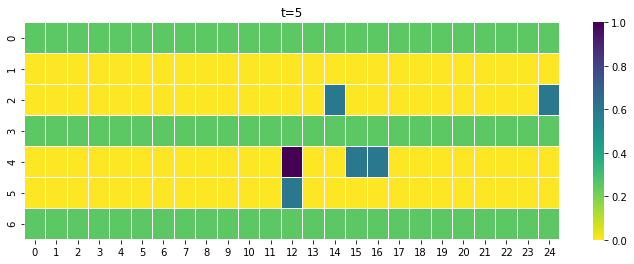

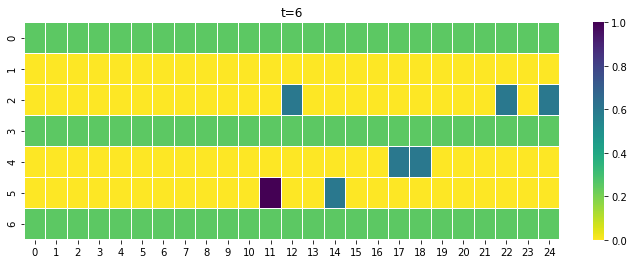

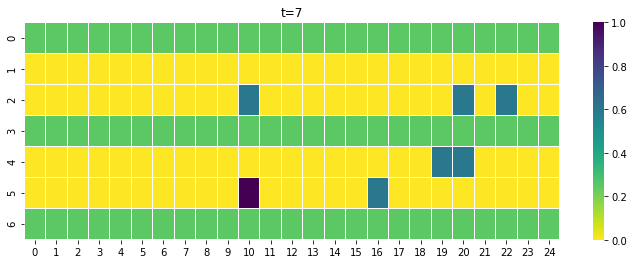

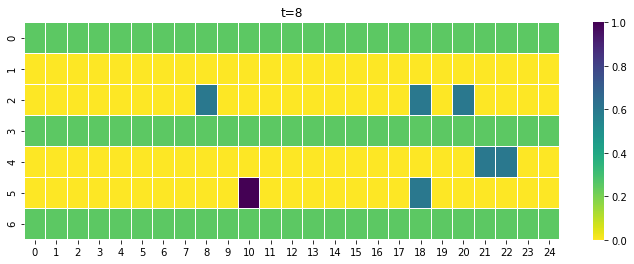

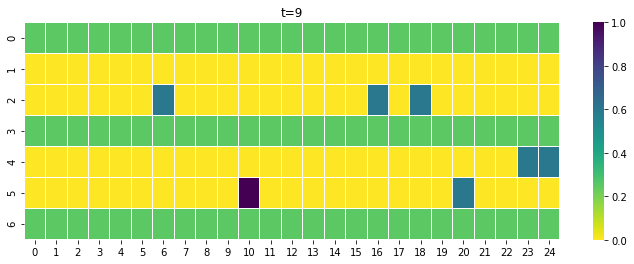

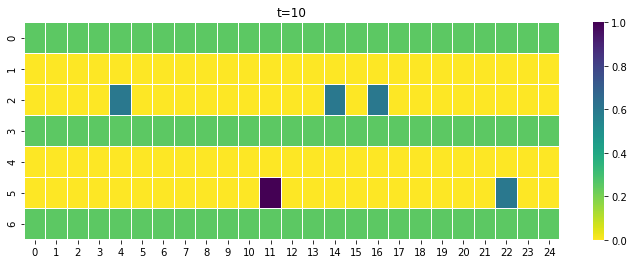

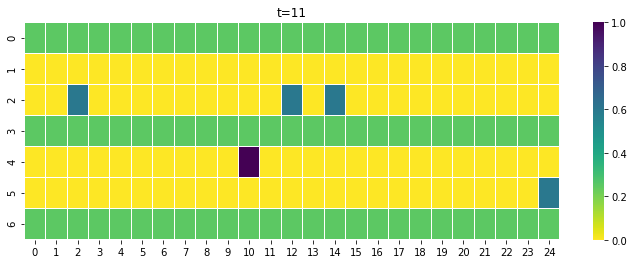

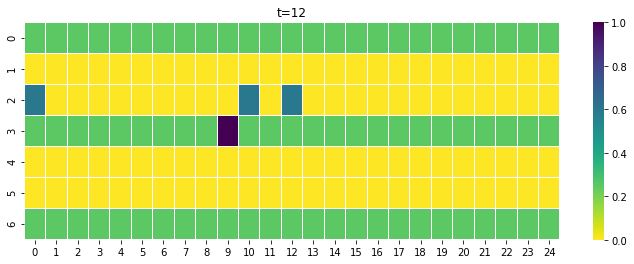

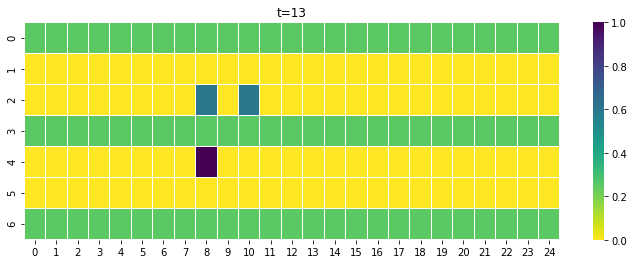

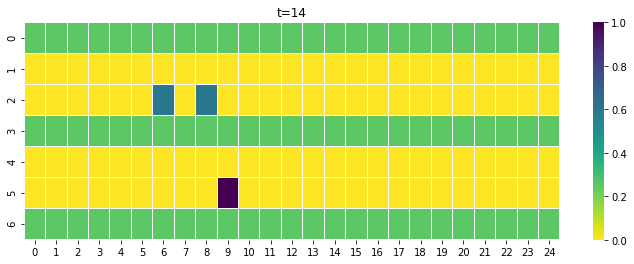

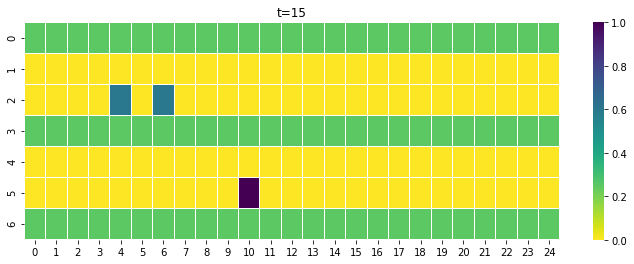

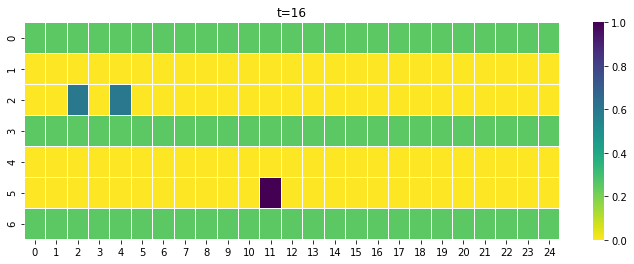

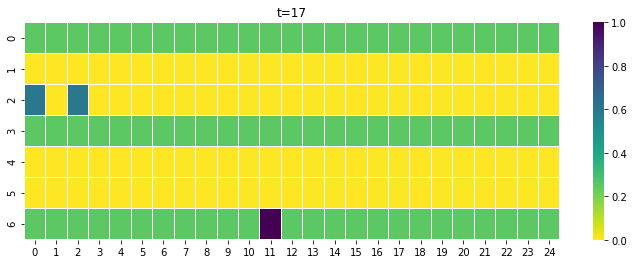

In [39]:
car_int = 0.05
hit = False
fin = False
new_dir = 180
time = 0
grid, sideways = create_grid(street_lanes=2, street_length=25, car_intensity=car_int)
plot(grid, time)

while hit != True and fin != True:
    time += 1
    grid, new_dir, hit, fin = model_step(grid, sideways, drunk_direction=new_dir, car_intensity=car_int, movement_type=calc_direction_b)
    plot(grid, time)

## C
-  t is exponentially distributed with intensity 1/time unit
- new direction = old direction +$\alpha$ with $\alpha$ is uniformly distributed in $[-2/3\pi; +2/3\pi]$

In [41]:
def calc_direction_c(last_direction, lam=1):
    
    # with lambda, roll number of movements in this step
    t = np.random.exponential(lam)
    nr_of_steps = int( min(np.rint(t**(-1)), 3) )
    
    dir_coords = np.zeros(2, dtype=np.int32)
    
    if nr_of_steps == 0:
        return tuple(dir_coords), last_direction, nr_of_steps
    
    else:
        for i in range(nr_of_steps):
            # roll persons movement for B
            # -(2/3)*math.pi, +(2/3)*math.pi --> -120°,120°
            new_direction = last_direction + np.random.uniform(-120, 120, 1)

            new_direction = new_direction%360 #modulo 
            
            if 337.5 <= new_direction < 22.5:
                dir_coords += (-1,0)
            elif 22.5 <= new_direction < 67.5:
                dir_coords += (-1,1)
            elif 67.5 <= new_direction < 112.5:
                dir_coords += (0,1)
            elif 112.5 <= new_direction < 157.5:
                dir_coords += (1,1)
            elif 157.5 <= new_direction < 202.5:
                dir_coords += (1,0)
            elif 202.5 <= new_direction < 247.5:
                dir_coords += (1,-1)
            elif 247.5 <= new_direction < 292.5:
                dir_coords += (0,-1) 
            elif 292.5 <= new_direction < 337.5:
                dir_coords += (-1,-1)

        return tuple(dir_coords), new_direction, nr_of_steps

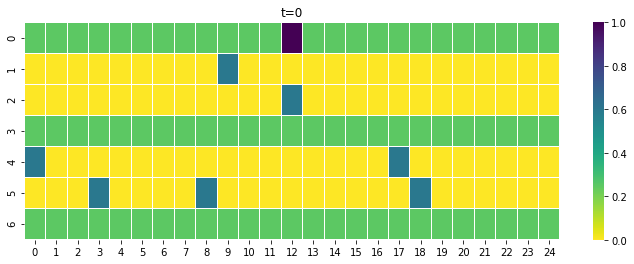

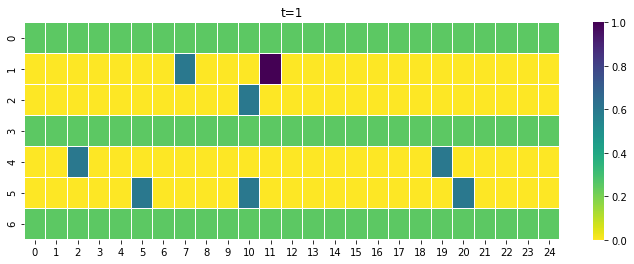

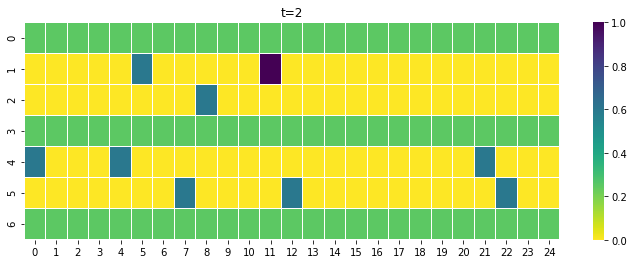

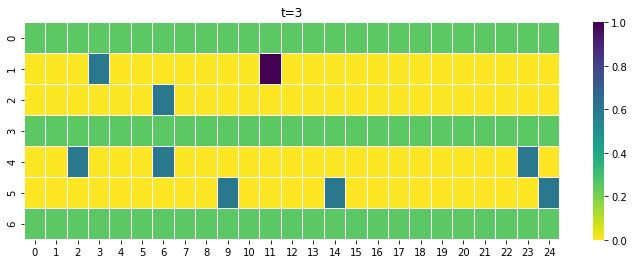

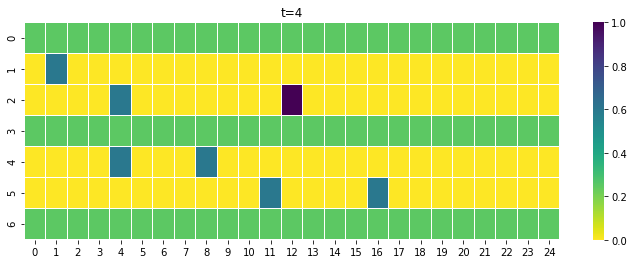

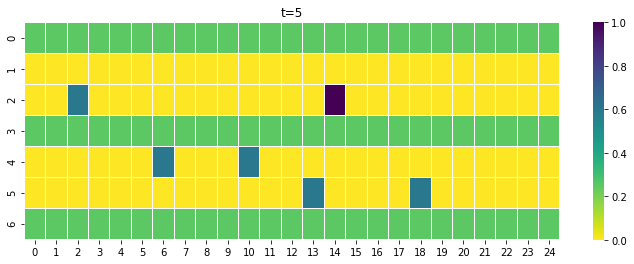

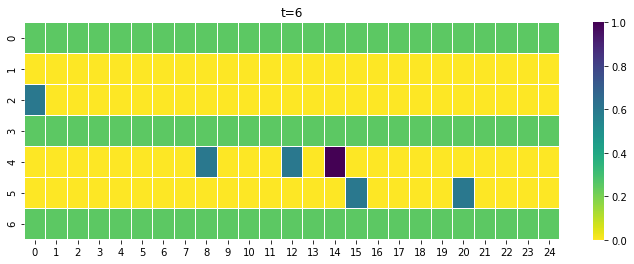

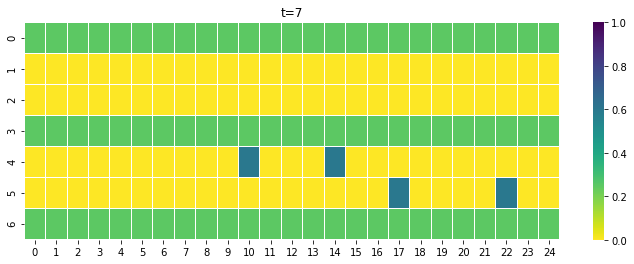

In [45]:
car_int = 0.05
hit = False
fin = False
new_dir = 180
time = 0
grid, sideways = create_grid(street_lanes=2, street_length=25, car_intensity=car_int)
plot(grid, time)

while hit != True and fin != True:
    time += 1
    grid, new_dir, hit, fin = model_step(grid, sideways, drunk_direction=new_dir, car_intensity=car_int, movement_type=calc_direction_c)
    plot(grid, time)


# Mass Simulations

## Simulate Deaths vs Successes

In [122]:
from tqdm import tqdm

def simulate_end_by_duration(n=100, street_lanes=2, street_length=25, car_int = 0.05, movement=calc_direction_a):    
    death_times = []
    succ_times = []
    
    # simulate n runs
    # for i in tqdm(range(n)):
    for i in range(n):
    
        # init
        hit = False
        fin = False
        direction = 180
        time = 0
        grid, sideways = create_grid(street_lanes=street_lanes, street_length=street_length, car_intensity=car_int)
        
        # start simulation
        while hit != True and fin != True:
            time += 1
            grid, new_dir, hit, fin = model_step(grid, 
                                                 sideways, 
                                                 drunk_direction=direction, 
                                                 car_intensity=car_int, 
                                                 movement_type=movement)
        if hit:
            death_times.append(time)
        if fin:
            succ_times.append(time)
    
    return succ_times, death_times

succ, death = simulate_end_by_duration(n=10000)

In [123]:
import plotly.express as px

# BAR PLOT
px.bar(x=['success', 'death'], 
       y=[len(succ), len(death)], 
       color=['success', 'death'], 
       title='Success vs Death (standard settigs, N=10k)')

## Simulate different car intensities

In [124]:
car_intensities = [i/100 for i in range(5, 100, 1)]
succs = []
deaths = []

for ci in tqdm(car_intensities):
    s, d =  simulate_end_by_duration(n=10000, car_int=ci)
    succs.append(s)
    deaths.append(d)

100%|██████████| 95/95 [11:23<00:00,  7.19s/it]


In [142]:
import numpy

mean_deaths = [np.mean(x) for x in deaths]
mean_succs = [np.mean(x) for x in succs]


fig = px.line(title='Average time for death or success (N=10k per car_intensity)')
fig.add_scatter(x=car_intensities, y=mean_succs, mode='lines', name='success')
fig.add_scatter(x=car_intensities, y=mean_deaths, mode='lines', name='death')
fig.update_xaxes(title_text='car intensity')
fig.update_yaxes(title_text='average time')
fig.show()